## Visualizing results of the First Edition -  SpaCy Geottaging + Edinburgh Georesolution

In this case, we have used the [SpaCy en_core_web_lg](https://spacy.io/models/en#en_core_web_lg) for finding the Name Entities of all the books of a particular edition,  and select the ones regarding with places (GPE and LOC entities). Later, once we have the locations entities, we use the [georesolver]() of the  [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) to resolve these locations.

We have used the books of the **First Edition ** of the Encyclopaedia Britannica. 
                             
The query for running that we have used is the following: 

`spark-submit --py-files defoe.zip defoe/run_query.py nls_first_edition.txt nls defoe.nls.queries.georesolution_pages queries/lang_model.yml -r georesolution_en_core_web_lg_EB_first_edition' -n 16`

The nls_first_edition.txt has the path of this particular book that we are exploring:
`
/home/tdm/datasets/nls-data-encyclopaediaBritannica/144133901
/home/tdm/datasets/nls-data-encyclopaediaBritannica/144133902
/home/tdm/datasets/nls-data-encyclopaediaBritannica/144133903
/home/tdm/datasets/nls-data-encyclopaediaBritannica/144850366
/home/tdm/datasets/nls-data-encyclopaediaBritannica/144850367
/home/tdm/datasets/nls-data-encyclopaediaBritannica/144850368`

And the queries/lang_model.yml specifies the spaCy language model to use:
`lang_model: en_core_web_lg`

The results file ( [eoresolution_en_core_web_lg_EB_first_edition](http://localhost:8888/edit/results_NLS/georesolution_en_core_web_lg_EB_first_edition) ) is stored in this repository under the *results_NLS* subdirectory. 

Note: We just perfomed this study using all the pages of one boo. But we could run this query using the full EB dataset.


### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

### Functions

In [2]:
def read_query_results(filename):
    with open('./results_NLS/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def display_spacy_entities(result):
    for i in result.keys():
        for k in result[i]:
            html= k["display_doc"]
            if html:
                print(" \n ----- %s: Entities with the Spacy \"%s\" language model  ----- \n" % (k["text_unit id"], k["lang_model"]))
                display(HTML(html))

In [4]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]
    for i in result.keys():
        t_ind = 0
        e_ind = 0
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
       
            if locs != {}:
                data=[]
                l_ind = 0
                for i in locs:
                    if type(locs[i]) == type([]) :
                        c_locs=locs[i].copy()
                        c_locs.append(i.split("-")[0])
                        c_locs.append(page)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [5]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df_total['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [6]:
def label_freq_places(df_total, df_max_geolocations):
    place_label=[]
    place_freq = []
    for i in range(0,15):
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'] )
        print(i, place_count,place_name)
        place_label.append(place_name)
        place_freq.append(place_count)
    return place_label, place_freq

In [7]:
def plot_bar_places(place_label, place_freq):
    # this is for plotting purpose
    index = np.arange(len(place_label))
    plt.bar(index, place_freq)
    plt.xlabel('Places', fontsize=10)
    plt.ylabel('Frequency of Places', fontsize=5)
    plt.xticks(index, place_label, fontsize=8, rotation=40)
    plt.title('15 Places most mentioned')
    plt.show()

### Information about the defoe georesolution query

This query does the following tasks:

- Ingests all the pages from all the books of the first edition
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities* using the original SpaCy en_core_web_lg model.
- From the previous entities, just selects the one about *location* (GPE and LOC) and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by Book's title, and also gets some informative metadata

As a result we get a file per gazetter|book with an entry per page with the following information:

    * archive_filename: Path to the gazetteer 
    * clean_text: Page's clean text after applying 2 fixes: long-S and hyphenate words
    * display_doc: HTML string with the name entities detected by spacy for each page
    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver
    * model: defoe model – could be fmp|nls|papers|alto. In this case is “nls”
    * text_unit: page (for other defoe models could be “article”)
    * num_text_unit: number of tex units. In this case, number of pages of this particular book (e.g. 832)
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (e.g. en_core_web_lg)
    * type_distribution: type of document (newspaper|book). In this case is "book". 
    * year: Publication year 


Example:
  - archive_filename: /home/tdm/datasets/encyclopaedia-britannica-sample/144133901
  - clean_text: "ARTS and SCIENCES, COVI PILED UPON A NEW PLAN. IN WHICH The diferent
    SCIENCES and ARTS are dioefted into " O diflinct Treatifes or Syitems; AND . The
    \irious TECHNIC A LTERMS, <&C. are explained as they occur in the order of the
    Alphabet. ILLUSTRATED WITH ONE HUNDRED AND SIXTY COPPERPLATES. fry a SOCIETY of
    GENTLEMEN in SCOTLAND .... "
  - display_doc:"<div class=\"entities\" style=\"line-height: 2.5; direction: ltr\"\
    >ARTS and SCIENCES, COVI PILED UPON A NEW PLAN. IN WHICH The diferent SCIENCES\
    \ and ARTS .... "
  - edition: First edition, 1771, Volume 1, A-B
  - georesolution_page:
    SCOTLAND-rb3:
        - '57.68633318560074'
        - '-4.96890721218449'
  - lang_model: en_core_web_lg
  - model: nls
  - num_text_unit: 832
  - page_filename: alto/188082826.34.xml
  - place: Edinburgh
  - text_unit: page
  - text_unit id: Page9
  - type_distribution: book
  - year: 1771



In [8]:
results=read_query_results('georesolution_en_core_web_lg_EB_first_edition')

In [9]:
#display_spacy_entities(results)

In [10]:
df_total= geresolution_dataframe(results)

In [11]:
df_total.head(10)

,Latitude,Longitude,Place,Page
0,57.68633318560074,-4.96890721218449,SCOTLAND,Page9
1,40.23966095585345,-120.3136185374944,Honey,Page12
2,35.1673393,-82.0267752,Africa,Page15
3,38.8287265,-76.5430142,Bahama,Page15
4,44.8374628,-93.6407923,Bavaria,Page15
5,-22.42986419063092,-44.84001624257252,Mina,Page15
6,51.31831624554659,0.8328280141845815,Barbary,Page15
7,50.6522111706725,-3.615645583175173,France,Page15
8,35.632905,-81.76926520000001,England,Page15
9,48,9,Swabia,Page15


In [12]:
df_total[["Place"]].count()

Place    34400
dtype: int64

In [13]:
df_total.sum()

Latitude     57.6863331856007440.2396609558534535.167339338...
Longitude    -4.96890721218449-120.3136185374944-82.0267752...
Place        SCOTLANDHoneyAfricaBahamaBavariaMinaBarbaryFra...
Page         Page9Page12Page15Page15Page15Page15Page15Page1...
dtype: object

In [14]:
df_total.groupby("Place").count()

,Latitude,Longitude,Page
Place,,,
".004629,629",1,1,1
1 Berlin,1,1,1
"314,159,265,358,979,323.846,264,338,327,951",2,2,2
3d,34,34,34
"5,",1,1,1
A,1,1,1
A.C,1,1,1
ABERDEEN,2,2,2
ABM,1,1,1


In [15]:
df_total.groupby("Page").count()

,Latitude,Longitude,Place
Page,,,
Page10,15,15,15
Page100,12,12,12
Page1000,1,1,1
Page1003,2,2,2
Page1005,2,2,2
Page1008,1,1,1
Page1009,6,6,6
Page101,48,48,48
Page1010,36,36,36


In [16]:
df_total.groupby(["Latitude", "Longitude"]).count()

,,Place,Page
Latitude,Longitude,,
-0.1366818175840478,100.6383162769587,24,24
-0.1544928803232608,-78.44005994797827,2,2
-0.4833333,-79.7166667,2,2
-0.6525817868904085,14.88498763015494,5,5
-0.8333333000000001,34.1666667,1,1
-0.8807308898496728,110.0650130543025,2,2
-1.5333333,-79.45,1,1
-1.612304376145943,132.4901872090725,6,6
-1.7535,120.6485,2,2


In [21]:
df_filter = df_total[['Latitude','Longitude']].groupby(['Latitude', 'Longitude'])['Longitude'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)     

# removing the first forw
df_max_geolocations=df_filter
#df_filter.drop([0])
# getting the 10 GEOLOCATIONS more repeated
df_max_geolocations.head(10)

,Latitude,Longitude,count
3887,54.31925079960345,-2.232838508197517,1193
3181,50.6522111706725,-3.615645583175173,908
1361,38.3242916,-76.5168989,708
834,33.130599,-116.2994551,697
3284,51.16809234634502,10.43727461748782,663
4082,59.22022125858783,25.35590660898998,647
3676,52.66970530850324,-1.117070990383866,504
318,10.65684336992561,-61.52036078532194,483
2095,41.80022665055388,12.84764018726517,481
2633,45.2425296081972,-94.88857066304371,470


In [22]:
#place_count, place_name= get_place(df_total, '50.6522111706725', '-3.615645583175173')


In [23]:
#Getting the 15 places (and their frequencies) most mentioned
place_label, place_freq = label_freq_places(df_total, df_max_geolocations)

0 1193 Britain
1 908 France
2 708 earth
3 697 earth
4 663 Germany
5 647 Europe
6 504 England
7 483 Spain
8 481 Rome
9 470 America
10 453 Scotland
11 354 India
12 348 London
13 313 Paris
14 307 Italy


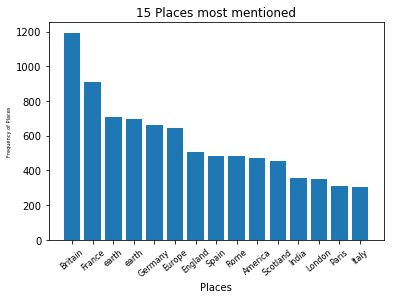

In [24]:
#Visualizing the 15 places in a Bar plot
plot_bar_places(place_label, place_freq)